In [430]:
# LLM tentative
# https://medium.com/international-school-of-ai-data-science/leveraging-lstm-and-llm-models-for-stock-price-prediction-79bf15d681ec

In [431]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [432]:
!pip install tensorflow
!pip install transformers
!pip install torch torchvision torchaudio
!pip install yfinance

In [433]:
# !pip uninstall keras

In [434]:
!pip install tf-keras

In [435]:
# import section
import pandas as pd
import yfinance as yf
import numpy as np
import torch
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TFGPT2LMHeadModel

In [436]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_columns = 100

In [437]:
# QUick check PyTorch is properly installed
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.0811, 0.1987, 0.6763],
        [0.6600, 0.3161, 0.1853],
        [0.5721, 0.5711, 0.2557],
        [0.9847, 0.3074, 0.9188],
        [0.1432, 0.3759, 0.9921]])


In [438]:
import torch
torch.cuda.is_available()

False

In [439]:
ticker = "AAPL"
start_date = "2023-01-01"
end_date = "2023-06-08"
data = yf.download(ticker, start=start_date, end=end_date)

prices = data["Close"].tolist()
print(len(prices))

[*********************100%%**********************]  1 of 1 completed

108


In [440]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,130.279999,130.899994,124.169998,125.070000,124.216293,112117500
2023-01-04,126.889999,128.660004,125.080002,126.360001,125.497498,89113600
2023-01-05,127.129997,127.769997,124.760002,125.019997,124.166634,80962700
2023-01-06,126.010002,130.289993,124.889999,129.619995,128.735245,87754700
2023-01-09,130.470001,133.410004,129.889999,130.149994,129.261612,70790800
...,...,...,...,...,...,...
2023-06-01,177.699997,180.119995,176.929993,180.089996,179.381607,68901800
2023-06-02,181.029999,181.779999,179.259995,180.949997,180.238220,61945900
2023-06-05,182.630005,184.949997,178.039993,179.580002,178.873627,121946500


Tokenizing Historical Prices and Fine-tuning the Model

Fine-tuning GPT model on Historical Data

In [441]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

In [442]:
# Quick display of what we are going to feed to the model
num_outputs = 3
for i, price in enumerate(prices):
    if i >= num_outputs:
        break
    my_string = str(price)
    # print (f"Price {i+1}: {my_string})
    print(my_string)


125.06999969482422
126.36000061035156
125.0199966430664


In [443]:
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

encoded_prices = tokenizer.encode(" ".join([str(price) for price in prices]), return_tensors="pt")


In [446]:
encoded_prices

tensor([[11623,    13,  3312, 24214,  3388,  2780,  1731,  1828, 19710,    13,
          2623,  2388, 39132,  2327, 21599, 13151,    13,   486,  2079,  4846,
          2414, 20548,  2414, 20248,    13,    21, 18946,    20, 17657,  1507,
          2425, 11323,    13,  1415, 17032, 29769,  2414,  5705,  2548, 11323,
            13, 48555,  2079,  3553, 23195,  2670,  3312, 22169,    13,  2920,
           830, 44966, 33400, 29703, 22169,    13,  3901,   830,  2623,  5237,
         14454,  2548, 22352,    13,  2425,  2079,  5824,  1120,  3104,  2327,
          5824, 17501,    13,  5824,   830, 25707,  1415,  3312,  1495, 17501,
            13,  2481,   830,  3134, 20107, 43864, 17501,    13,  1983,   830,
         42363,  1731,  1899,  5824, 21643,    13,  4521,  2079,  3865, 17657,
          1507,  2425, 25500,    13,  1157,  2388, 39132,  2327, 21599, 25181,
            13, 49721, 34808, 40393,  1959, 34427, 25500,    13,  4521,  2388,
         39132,  2327, 21599, 24356,    13,  4846,  

Fine-tuning the Model

The historical stock prices are tokenized and used to fine-tune the GPT-2 model. The model is trained for three epochs using an Adam optimizer

In [447]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
model.resize_token_embeddings(len(tokenizer))



GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Embedding(50257, 768)

fine-tune the GPT-2 model

In [448]:
print(len(tokenizer))

50257


In [449]:
for _ in range(3):
    model.zero_grad()
    outputs = model(encoded_prices, labels=encoded_prices)
    loss = outputs.loss
    loss.backward()
    optimizer.step()

In [450]:
outputs

CausalLMOutputWithCrossAttentions(loss=tensor(2.8942, grad_fn=<NllLossBackward0>), logits=tensor([[[ -55.1056,  -53.1038,  -54.3826,  ...,  -61.0666,  -62.4690,
           -54.1758],
         [ -89.1024,  -87.4743,  -87.8781,  ...,  -94.7485,  -94.6709,
           -83.6525],
         [ -95.6576,  -93.7860,  -94.2105,  ..., -104.2899, -104.7693,
           -94.5385],
         ...,
         [ -96.4838,  -93.8987,  -96.8740,  ..., -106.7398, -104.5455,
           -92.6164],
         [ -27.1408,  -25.6651,  -28.1498,  ...,  -37.9106,  -40.5656,
           -24.3317],
         [-101.5723, -102.8514, -103.0612,  ..., -114.4420, -113.3739,
          -100.4080]]], grad_fn=<UnsafeViewBackward0>), past_key_values=((tensor([[[[-1.0189,  1.9868,  0.5121,  ..., -0.9044, -0.4431,  1.6374],
          [-2.1242,  2.9484,  1.5618,  ..., -0.0853, -1.7288,  1.8110],
          [-1.5400,  3.5833,  1.3994,  ..., -0.4634, -2.0014,  2.0410],
          ...,
          [ 0.7235, -2.9335, -1.7334,  ...,  0.0943,  2

Using historical stock price data, this code refines a pre-trained GPT model to
produce future prices.

In [451]:
flattened_encoded_prices = encoded_prices.view(-1)

Generating Future Prices

In [452]:
generated = model.generate(encoded_prices, max_length=encoded_prices.numel() + 1, temperature=1.0, num_return_sequences=1)
generated_prices = tokenizer.decode(generated[0], skip_special_tokens=True).split()

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [453]:
encoded_prices

tensor([[11623,    13,  3312, 24214,  3388,  2780,  1731,  1828, 19710,    13,
          2623,  2388, 39132,  2327, 21599, 13151,    13,   486,  2079,  4846,
          2414, 20548,  2414, 20248,    13,    21, 18946,    20, 17657,  1507,
          2425, 11323,    13,  1415, 17032, 29769,  2414,  5705,  2548, 11323,
            13, 48555,  2079,  3553, 23195,  2670,  3312, 22169,    13,  2920,
           830, 44966, 33400, 29703, 22169,    13,  3901,   830,  2623,  5237,
         14454,  2548, 22352,    13,  2425,  2079,  5824,  1120,  3104,  2327,
          5824, 17501,    13,  5824,   830, 25707,  1415,  3312,  1495, 17501,
            13,  2481,   830,  3134, 20107, 43864, 17501,    13,  1983,   830,
         42363,  1731,  1899,  5824, 21643,    13,  4521,  2079,  3865, 17657,
          1507,  2425, 25500,    13,  1157,  2388, 39132,  2327, 21599, 25181,
            13, 49721, 34808, 40393,  1959, 34427, 25500,    13,  4521,  2388,
         39132,  2327, 21599, 24356,    13,  4846,  

The fine-tuned model is then used to generate future stock prices based on the historical data.

Plotting the Results - Original Code

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Stock Price')

Text(0.5, 1.0, 'AAPL - Historical and Predicted Stock Prices (GPT)')

(array([19358., 19389., 19417., 19448., 19478., 19509.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19389.0, 0, '2023-02'),
  Text(19417.0, 0, '2023-03'),
  Text(19448.0, 0, '2023-04'),
  Text(19478.0, 0, '2023-05'),
  Text(19509.0, 0, '2023-06')])

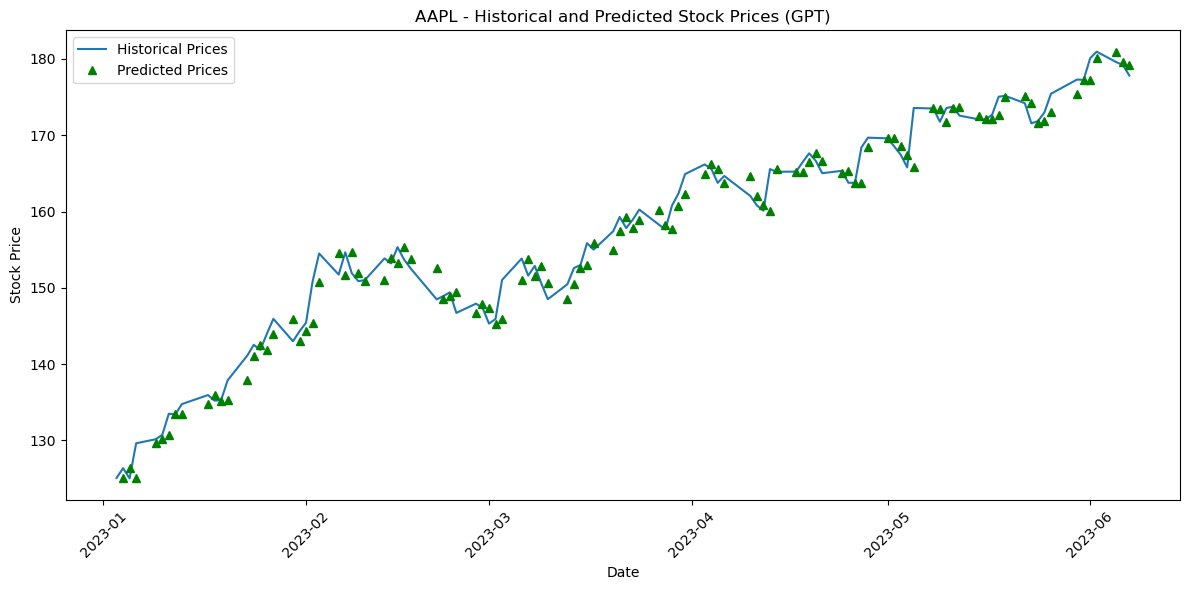

In [458]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, prices, label="Historical Prices")
plt.plot(data.index[1:], [float(price) for price in generated_prices[:len(prices)-1]], "g^", label="Predicted Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title(f"{ticker} - Historical and Predicted Stock Prices (GPT)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()